<font size=5>DSCI-552 Homework5



#### Name: Boyu Shen
#### Github username: boyushen0701
#### USC ID: 3547352504

In [2]:
import pandas as pd
from sklearn import tree
import pydotplus
from sklearn.model_selection import KFold,cross_val_score
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn import preprocessing
from sklearn.decomposition import PCA
import xgboost as xgb

<font size=5> 1. Decision Trees as Interpretable Models


(a) Download the Accute Inflamations data from https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations.

In [5]:
data=pd.read_csv('../data/diagnosis.csv',sep='\t',encoding='UTF_16',decimal=',',header=None)
data.columns=['Temperature','Nausea','Lumbar pain','Urine pushing','Micturition pain','Urethra abnormal','Inflammation of urinary bladder','Nephritis']
data.replace('no',0,inplace=True)
data.replace('yes',1,inplace=True) # 0 represents no and 1 represents yes
data #take a look at the data

,Temperature,Nausea,Lumbar pain,Urine pushing,Micturition pain,Urethra abnormal,Inflammation of urinary bladder,Nephritis
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,0,1
116,41.5,0,0,0,0,0,0,0
117,41.5,1,1,0,1,0,0,1
118,41.5,0,1,1,0,1,0,1


(b) Build a decision tree on the whole data set and plot it.

In [8]:
from sklearn import tree

model1=tree.DecisionTreeClassifier(criterion='gini')
model1.fit(data.iloc[:,:-2],data.iloc[:,-2:])
with open("out.dot", 'w') as f :
    f = tree.export_graphviz(model1, out_file = f,
            feature_names = data.columns[:-2])

In [9]:
import pydotplus

dot_data = tree.export_graphviz(model1, out_file=None,feature_names=data.columns[:-2],
 filled=True, rounded=True, special_characters=True)
 
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("tree1.pdf") # plot the decision tree

True

From the output pdf file, we can observe that 6 regions in the features space are split by the decision tree. From left to right, first region 
(Temperature ≤ 37.95 and Urine pushing=no) contains 20 samples with Inflammation of urinary bladder as no and Nephritis as no. Second region 
contains 40 samples with Inflammation of urinary bladder as yes and Nephritis as no. Third region contains 10 samples with Inflammation of 
urinary bladder as no and Nephritis as no. Fourth region contains 21 samples with Inflammation of urinary bladder as no and Nephritis as yes. 
Fifth region contains 10 samples with Inflammation of urinary bladder as no and Nephritis as yes. Sixth region contains 19 samples with 
Inflammation of urinary bladder as yes and Nephritis as yes.

[Text(0.4, 0.9, 'X[0] <= 37.95\ngini = 0.493\nsamples = 120\nvalue = [[61, 59]\n[70, 50]]'),
 Text(0.2, 0.7, 'X[3] <= 0.5\ngini = 0.222\nsamples = 60\nvalue = [[20, 40]\n[60, 0]]'),
 Text(0.1, 0.5, 'gini = 0.0\nsamples = 20\nvalue = [[20, 0]\n[20, 0]]'),
 Text(0.3, 0.5, 'gini = 0.0\nsamples = 40\nvalue = [[0, 40]\n[40, 0]]'),
 Text(0.6, 0.7, 'X[2] <= 0.5\ngini = 0.355\nsamples = 60\nvalue = [[41, 19]\n[10, 50]]'),
 Text(0.5, 0.5, 'gini = 0.0\nsamples = 10\nvalue = [[10, 0]\n[10, 0]]'),
 Text(0.7, 0.5, 'X[4] <= 0.5\ngini = 0.236\nsamples = 50\nvalue = [[31, 19]\n[0, 50]]'),
 Text(0.6, 0.3, 'gini = 0.0\nsamples = 21\nvalue = [[21, 0]\n[0, 21]]'),
 Text(0.8, 0.3, 'X[3] <= 0.5\ngini = 0.226\nsamples = 29\nvalue = [[10, 19]\n[0, 29]]'),
 Text(0.7, 0.1, 'gini = 0.0\nsamples = 10\nvalue = [[10, 0]\n[0, 10]]'),
 Text(0.9, 0.1, 'gini = 0.0\nsamples = 19\nvalue = [[0, 19]\n[0, 19]]')]

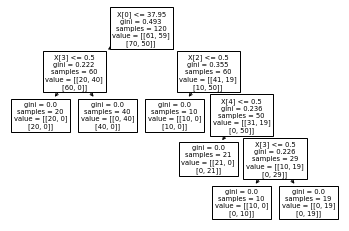

In [10]:
tree.plot_tree(model1)

(c) Convert the decision rules into a set of IF-THEN rules.

In [11]:
def tree_to_pseudo(tree, feature_names):

    '''
    Outputs a decision tree model as if/then pseudocode
    
    Parameters:
    -----------
    tree: decision tree model
        The decision tree to represent as pseudocode
    feature_names: list
        The feature names of the dataset used for building the decision tree
    '''

    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):
        indent = "  " * depth
        if (threshold[node] != -2):
            print (indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
            if left[node] != -1:
                recurse (left, right, threshold, features, left[node], depth+1)
                print (indent,"} else {")
                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)
                print (indent,"}")
        else:
            print (indent,"return " + str(value[node]))

    recurse(left, right, threshold, features, 0)

In [12]:
tree_to_pseudo(model1,data.columns[:-2])

 if ( Temperature <= 37.95000076293945 ) {
   if ( Urine pushing <= 0.5 ) {
     return [[20.  0.]
 [20.  0.]]
   } else {
     return [[ 0. 40.]
 [40.  0.]]
   }
 } else {
   if ( Lumbar pain <= 0.5 ) {
     return [[10.  0.]
 [10.  0.]]
   } else {
     if ( Micturition pain <= 0.5 ) {
       return [[21.  0.]
 [ 0. 21.]]
     } else {
       if ( Urine pushing <= 0.5 ) {
         return [[10.  0.]
 [ 0. 10.]]
       } else {
         return [[ 0. 19.]
 [ 0. 19.]]
       }
     }
   }
 }


(d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

In [13]:
path=model1.cost_complexity_pruning_path(data.iloc[:,:-2],data.iloc[:,-2:])
ccp_alphas, impurities=path.ccp_alphas, path.impurities
print(ccp_alphas)
print(path.impurities)

[0.         0.04908333 0.07947222 0.11111111 0.20423611]
[0.         0.09816667 0.17763889 0.28875    0.49298611]


In [14]:
from sklearn.model_selection import KFold,cross_val_score

score={}
for ccp_alpha in ccp_alphas:
    model=tree.DecisionTreeClassifier(random_state=0,ccp_alpha=ccp_alpha)
    scores=cross_val_score(model,data.iloc[:,:-2],data.iloc[:,-2:],scoring='accuracy',cv=4) 
    score[ccp_alpha]=sum(scores)/len(scores) # compute the average cv score for each alpha

print(score)

{0.0: 0.8083333333333333, 0.04908333333333333: 0.6, 0.07947222222222226: 0.5666666666666667, 0.1111111111111111: 0.425, 0.204236111111111: 0.0}


We can observe that for alpha=0, it has the best cross validation accuracy 0.8083333333333333.

[Text(0.4, 0.9, 'X[0] <= 37.95\ngini = 0.493\nsamples = 120\nvalue = [[61, 59]\n[70, 50]]'),
 Text(0.2, 0.7, 'X[3] <= 0.5\ngini = 0.222\nsamples = 60\nvalue = [[20, 40]\n[60, 0]]'),
 Text(0.1, 0.5, 'gini = 0.0\nsamples = 20\nvalue = [[20, 0]\n[20, 0]]'),
 Text(0.3, 0.5, 'gini = 0.0\nsamples = 40\nvalue = [[0, 40]\n[40, 0]]'),
 Text(0.6, 0.7, 'X[2] <= 0.5\ngini = 0.355\nsamples = 60\nvalue = [[41, 19]\n[10, 50]]'),
 Text(0.5, 0.5, 'gini = 0.0\nsamples = 10\nvalue = [[10, 0]\n[10, 0]]'),
 Text(0.7, 0.5, 'X[4] <= 0.5\ngini = 0.236\nsamples = 50\nvalue = [[31, 19]\n[0, 50]]'),
 Text(0.6, 0.3, 'gini = 0.0\nsamples = 21\nvalue = [[21, 0]\n[0, 21]]'),
 Text(0.8, 0.3, 'X[3] <= 0.5\ngini = 0.226\nsamples = 29\nvalue = [[10, 19]\n[0, 29]]'),
 Text(0.7, 0.1, 'gini = 0.0\nsamples = 10\nvalue = [[10, 0]\n[0, 10]]'),
 Text(0.9, 0.1, 'gini = 0.0\nsamples = 19\nvalue = [[0, 19]\n[0, 19]]')]

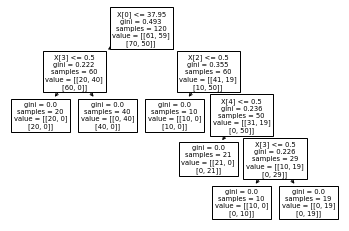

In [15]:
model_t=tree.DecisionTreeClassifier(ccp_alpha=ccp_alphas[0])
model_t.fit(data.iloc[:,:-2],data.iloc[:,-2:])
tree.plot_tree(model_t)

We can know that the tree is exactly the same as the tree in the question(b). Here are a set of decision rules with high interpretability.
<br>If Temperature ≤ 37.95 and Urine pushing is no, then Inflammation of urinary bladder is no and Nephritis is no. 
<br>If Temperature ≤ 37.95 and Urine pushing is yes, then Inflammation of urinary bladder is yes and Nephritis is no.
<br>If Temperature > 37.95 and Lumbar pain is no, then Inflammation of urinary bladder is no and Nephritis is no.
<br>If Temperature > 37.95 and Lumbar pain is yes and Micturition pain is no, then Inflammation of urinary bladder is no and Nephritis is yes.
<br>If Temperature > 37.95 and Lumbar pain is yes and Micturition pain is yes and Urine pushing is no, then Inflammation of urinary bladder is no and Nephritis is yes.
<br>If Temperature > 37.95 and Lumbar pain is yes and Micturition pain is yes and Urine pushing is yes, then Inflammation of urinary bladder is yes and Nephritis is yes


In [45]:
from sklearn.model_selection import KFold,cross_val_score

score={}
for ccp_alpha in ccp_alphas:
    model=tree.DecisionTreeClassifier(random_state=0,ccp_alpha=ccp_alpha)
    scores=cross_val_score(model,data.iloc[:,:-2],data.iloc[:,-2:],scoring='f1_samples',cv=4) # by multilabel sample
    score[ccp_alpha]=sum(scores)/len(scores) # compute the average cv score for each alpha

print(score)

E:\usc\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
E:\usc\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
E:\usc\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
E:\usc\anaconda\lib\site-packages\sklearn\metrics

{0.0: 0.5833333333333333, 0.04908333333333333: 0.5305555555555554, 0.07947222222222226: 0.5305555555555554, 0.1111111111111111: 0.5305555555555554, 0.204236111111111: 0.10555555555555557}


We can observe that for alpha=0.04908333333333333,0.07947222222222226, 0.1111111111111111, they all have the same cv f1 score, slightly less 
than the score where alpha=0, so in order to find a minimal decision tree, I decided to choose alpha= 0.1111111111111111.

[Text(0.5, 0.75, 'X[0] <= 37.95\ngini = 0.493\nsamples = 120\nvalue = [[61, 59]\n[70, 50]]'),
 Text(0.25, 0.25, 'gini = 0.222\nsamples = 60\nvalue = [[20, 40]\n[60, 0]]'),
 Text(0.75, 0.25, 'gini = 0.355\nsamples = 60\nvalue = [[41, 19]\n[10, 50]]')]

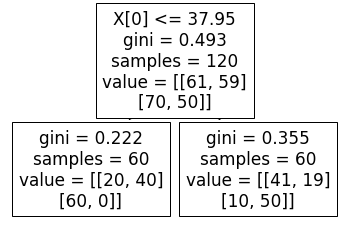

In [51]:
model2=tree.DecisionTreeClassifier(ccp_alpha=ccp_alphas[3])
model2.fit(data.iloc[:,:-2],data.iloc[:,-2:])
tree.plot_tree(model2)

We can observe that there are only 2 terminal nodes in this decision tree after cost-complexity pruning.

In [48]:
tree_to_pseudo(model2,data.columns[:-2])

 if ( Temperature <= 37.95000076293945 ) {
   return [[20. 40.]
 [60.  0.]]
 } else {
   return [[41. 19.]
 [10. 50.]]
 }


Besides, the decision rule is very interpretable. If Temperature <= 37.95000076293945, we predict Inflammation of urinary bladder as yes and 
Nephritis as no, if Temperature >37.95000076293945, we predict Inflammation of urinary bladder as no and Nephritis as yes.

<font size=5> 2. The LASSO and Boosting for Regression

(a) Download the Communities and Crime data from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as the training set and the rest as the test set.

(b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [3]:
columns=[]
for line in open('../data/communities.names'):
    if '@attribute' in line:
        sp=line.split(' ')
        columns.append(sp[1])

data2=pd.read_csv('../data/communities.csv',header=None,na_values='?',names=columns)
data2 #take a look at the data

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,9,9.0,80070.0,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,25,17.0,72600.0,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


In [4]:
# According to the data description, the first 5 columns are nonpredictive.
dataset=data2.iloc[:,5:]
dataset

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


In [5]:
trainingset=dataset[:1495]
testset=dataset[1495:]
trainingset

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,0.00,0.59,0.01,0.69,1.00,0.07,0.41,0.28,0.23,0.57,...,0.02,0.14,0.22,NaN,NaN,NaN,NaN,0.00,NaN,0.03
1491,0.16,0.62,0.03,0.74,0.48,0.42,0.44,0.57,0.40,0.25,...,0.07,0.40,0.14,0.07,0.05,0.85,0.5,0.61,0.19,0.20
1492,0.01,0.36,0.95,0.24,0.03,0.01,0.44,0.42,0.27,0.63,...,0.03,0.12,0.01,NaN,NaN,NaN,NaN,0.00,NaN,0.30
1493,0.06,0.53,0.01,0.98,0.05,0.01,0.40,0.40,0.24,0.29,...,0.08,0.15,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


In [6]:
import numpy as np
from sklearn.impute import SimpleImputer

Imp = SimpleImputer(missing_values=np.nan, strategy='mean') # Use mean value to impute the missing values
Imp.fit(trainingset)
trainingset=pd.DataFrame(Imp.transform(trainingset),columns=columns[5:])
trainingset

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,0.00,0.59,0.01,0.69,1.00,0.07,0.41,0.28,0.23,0.57,...,0.02,0.14,0.22,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03
1491,0.16,0.62,0.03,0.74,0.48,0.42,0.44,0.57,0.40,0.25,...,0.07,0.40,0.14,0.070000,0.050000,0.850000,0.500000,0.61,0.190000,0.20
1492,0.01,0.36,0.95,0.24,0.03,0.01,0.44,0.42,0.27,0.63,...,0.03,0.12,0.01,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.30
1493,0.06,0.53,0.01,0.98,0.05,0.01,0.40,0.40,0.24,0.29,...,0.08,0.15,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03


In [7]:
testset=pd.DataFrame(Imp.transform(testset),columns=columns[5:])
testset

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.00,0.20,0.03,0.91,0.23,0.05,0.15,0.19,0.09,0.42,...,0.01,0.23,0.73,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
1,0.00,0.55,0.13,0.78,0.15,0.36,0.48,0.53,0.30,0.10,...,0.01,0.18,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.11
2,0.00,0.52,0.04,0.59,0.05,0.62,0.84,0.78,0.75,0.43,...,0.01,0.18,0.00,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
3,0.04,0.51,0.07,0.92,0.09,0.03,0.38,0.47,0.27,0.35,...,0.06,0.13,0.16,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.06
4,0.03,0.59,0.20,0.75,0.19,0.10,0.38,0.62,0.35,0.11,...,0.03,0.23,0.06,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.09
495,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.45
496,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.080000,0.060000,0.780000,0.000000,0.91,0.280000,0.23
497,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.020000,0.020000,0.790000,0.000000,0.22,0.180000,0.19


(c) Plot a correlation matrix for the features in the data set.

In [10]:
whole_set=pd.concat([trainingset,testset],axis=0)
whole_set

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.09
495,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.45
496,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.080000,0.060000,0.780000,0.000000,0.91,0.280000,0.23
497,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.020000,0.020000,0.790000,0.000000,0.22,0.180000,0.19


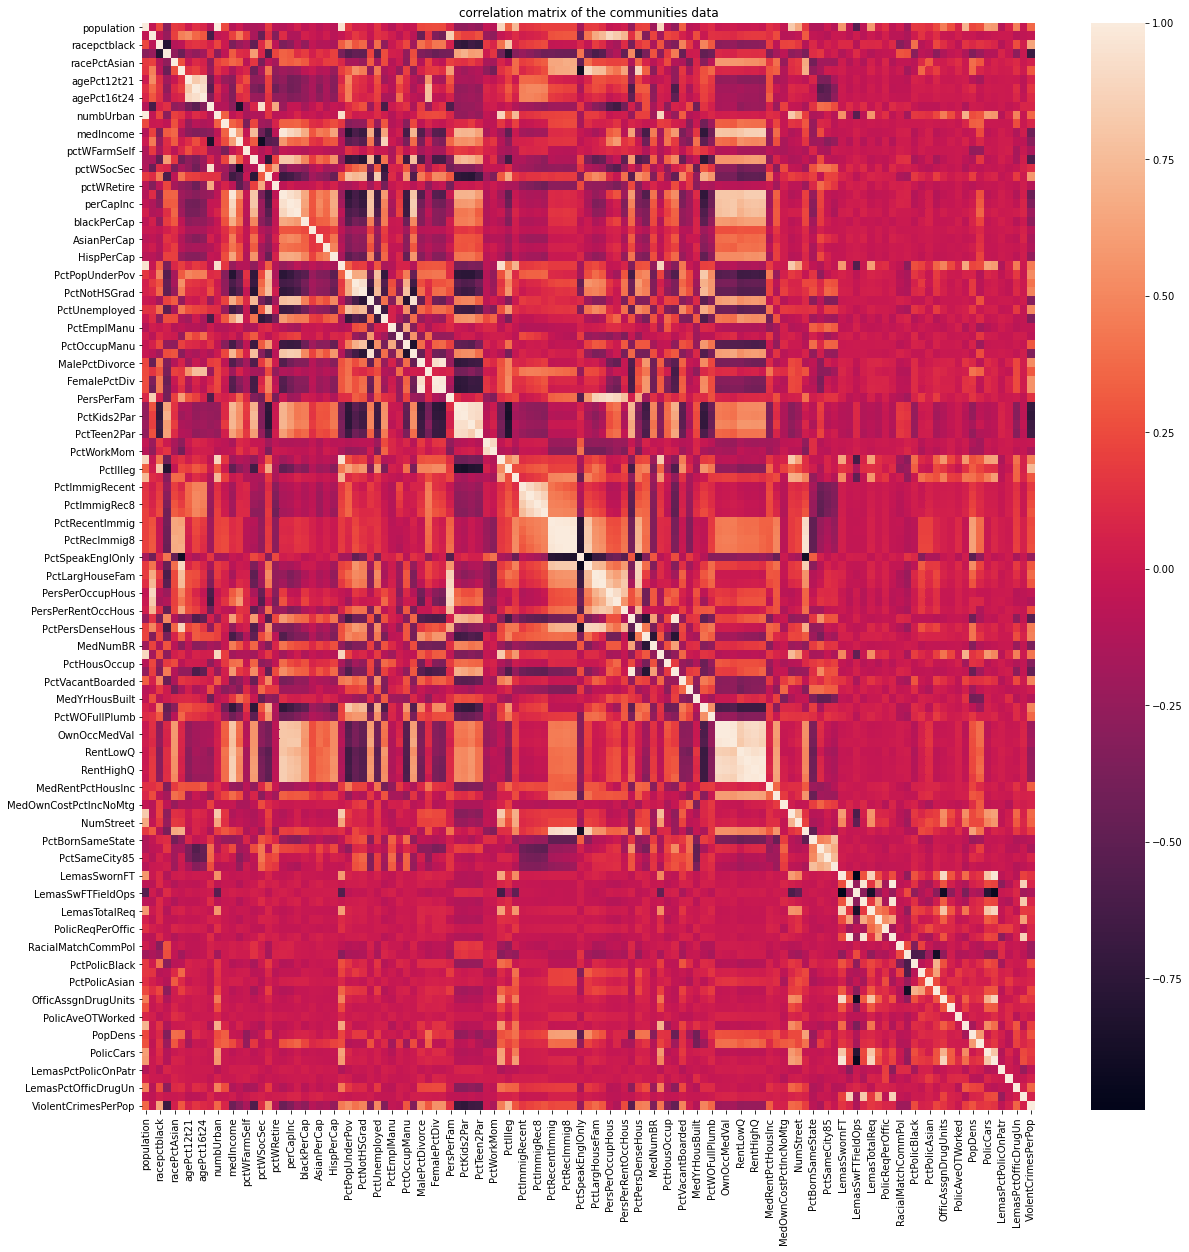

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

cor_matrix=whole_set.corr()
plt.figure(figsize=(20,20))
sns.heatmap(cor_matrix)
plt.title('correlation matrix of the communities data')
plt.show()

(d) Calculate the Coefficient of Variation CV for each feature, where CV = s/m, in which s is sample standard deviation and m is sample mean..

In [12]:
cvs=whole_set.std()/whole_set.mean()
CVs=pd.DataFrame(cvs[:-1], columns=["CV"]) # remove the dependent attribute
CVs

,CV
population,2.203503
householdsize,0.353298
racepctblack,1.410920
racePctWhite,0.323782
racePctAsian,1.359162
...,...
PolicOperBudg,0.701202
LemasPctPolicOnPatr,0.120471
LemasGangUnitDeploy,0.360299
LemasPctOfficDrugUn,2.555266


(e) Pick ⌊√128⌋ features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about 
significance of those features, just by the scatter plots?

In [13]:
CVsort=CVs.sort_values('CV',ascending=False)
CVsort

,CV
NumStreet,4.407702
NumInShelters,3.485481
NumIlleg,2.994196
NumImmig,2.900497
LemasPctOfficDrugUn,2.555266
...,...
NumKindsDrugsSeiz,0.146867
RacialMatchCommPol,0.132619
PctPolicWhite,0.121894
LemasPctPolicOnPatr,0.120471


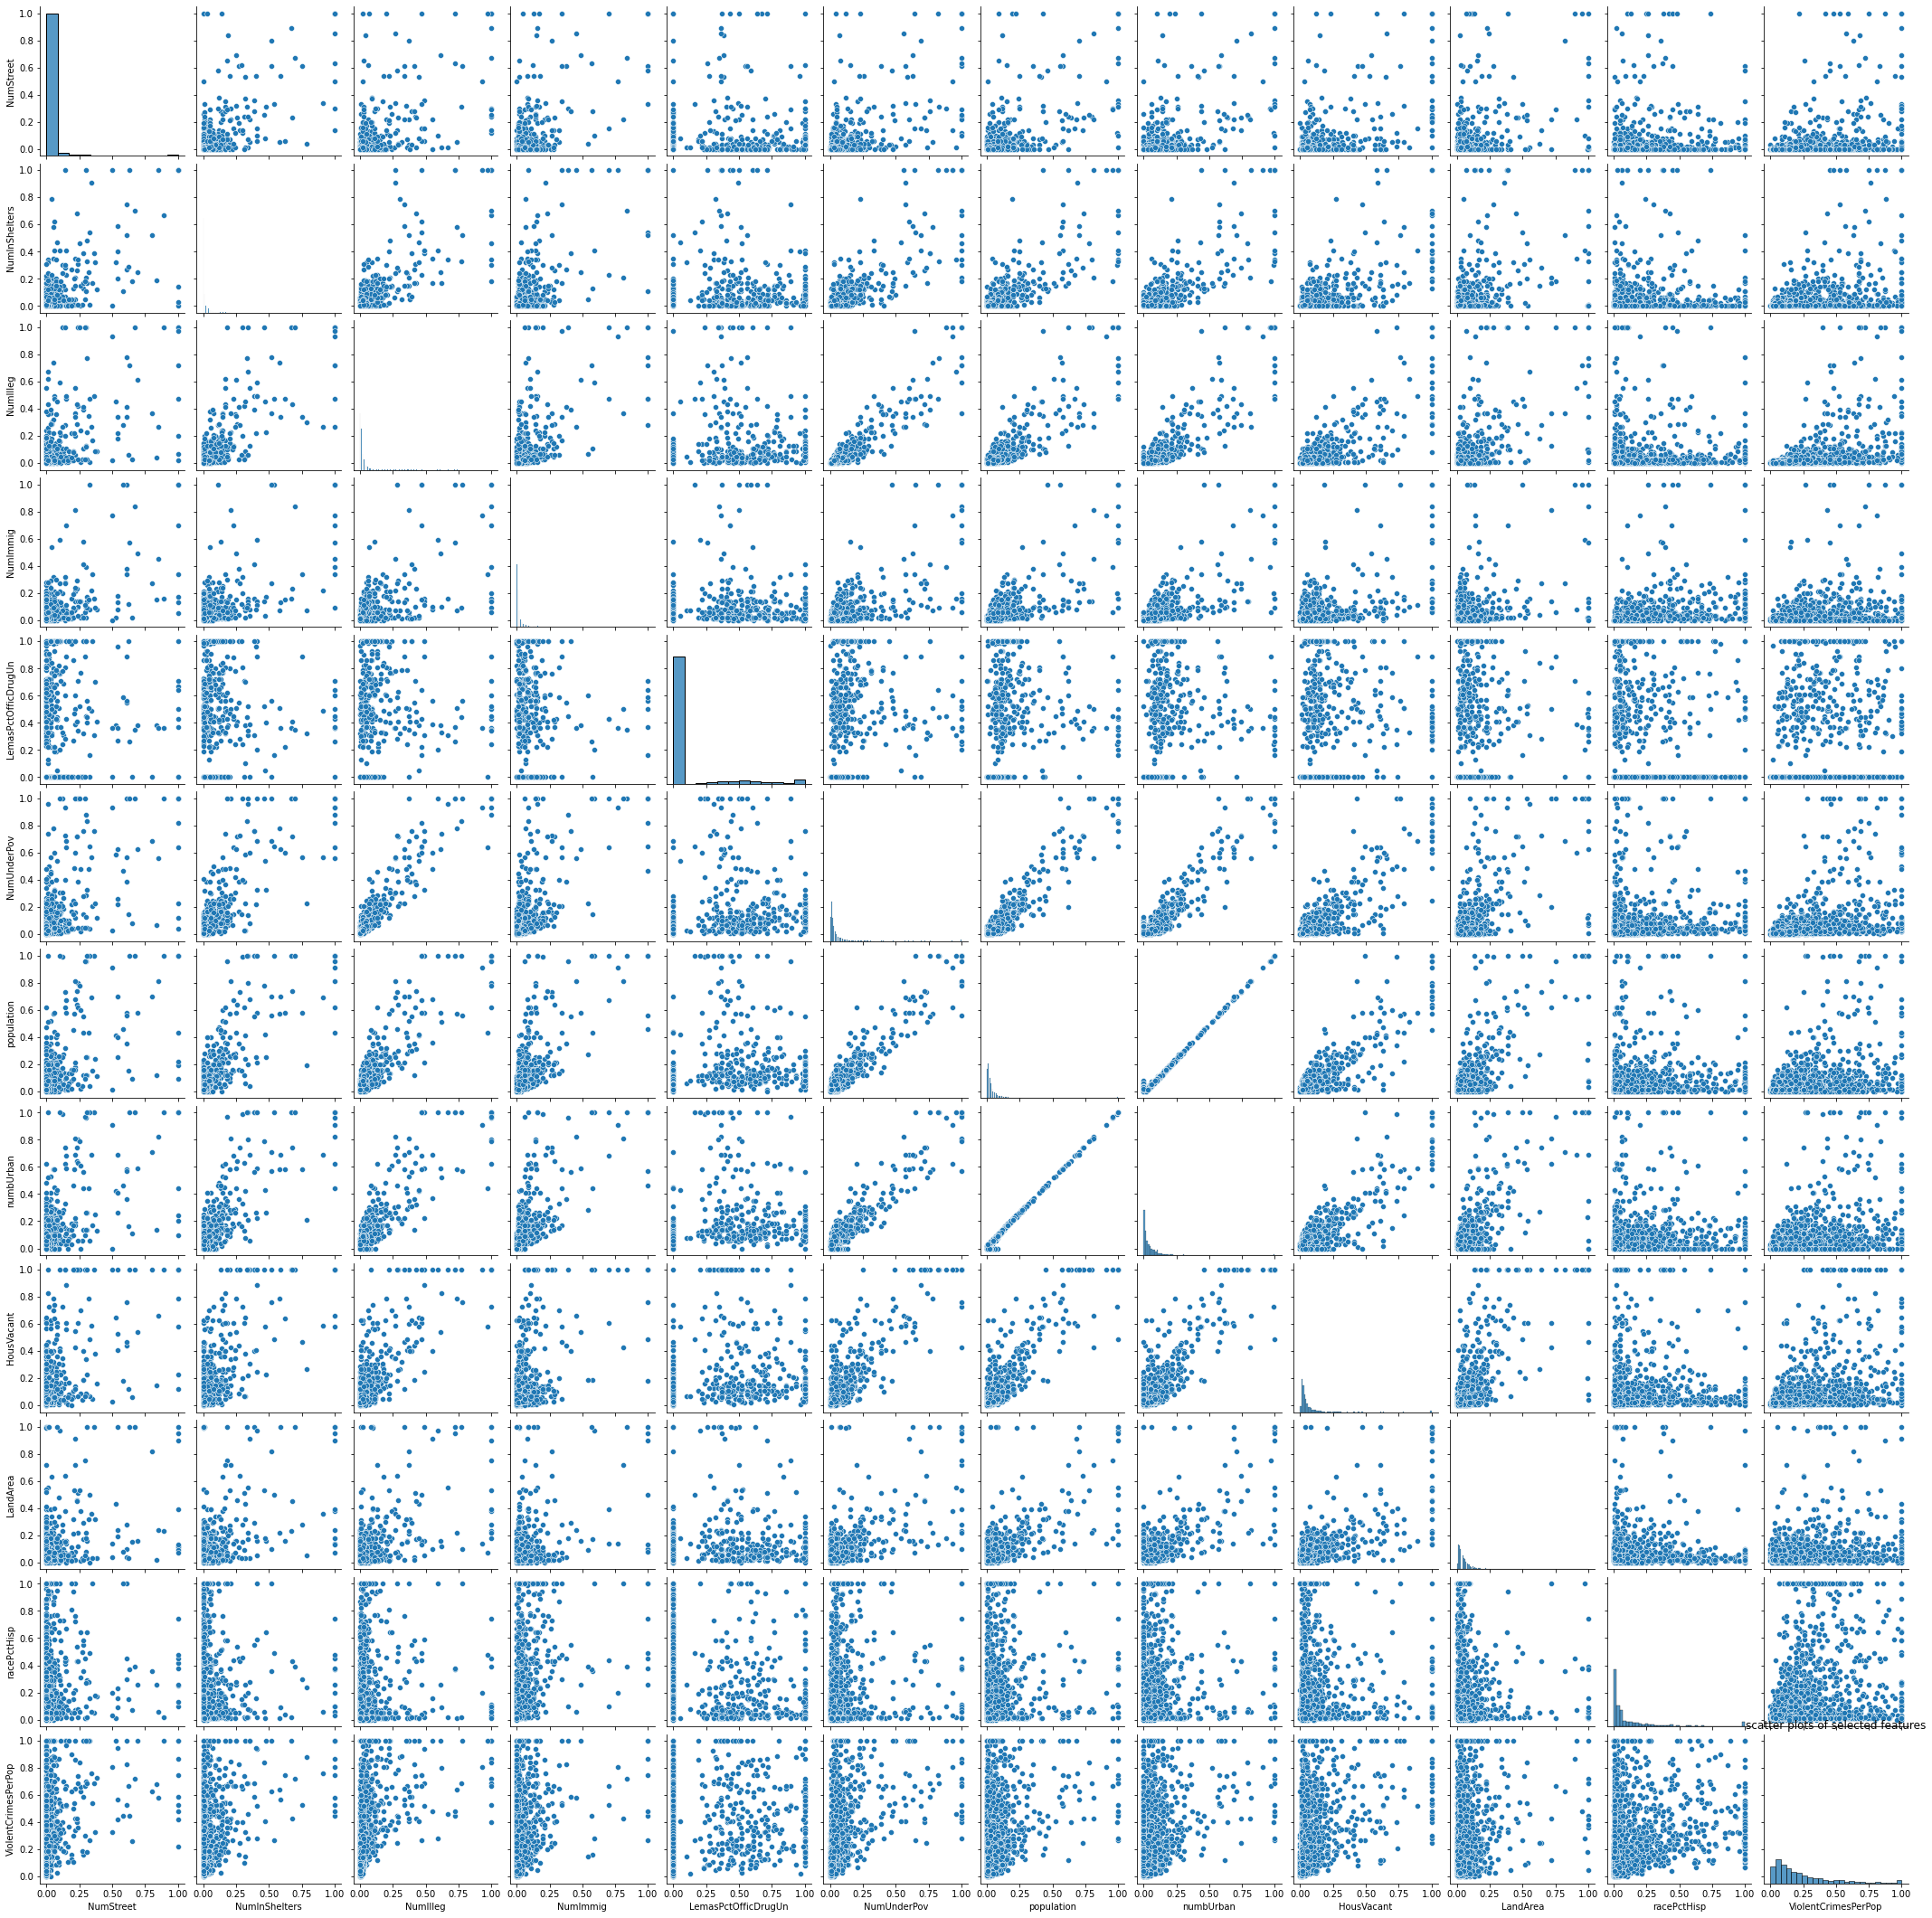

In [14]:
import math

l=math.floor(128**0.5)
selected_features=CVsort.index[:l].tolist()
selected_features.append('ViolentCrimesPerPop') # add the target variable
sns.pairplot(whole_set,vars=selected_features)
plt.title('scatter plots of selected features')
plt.show()

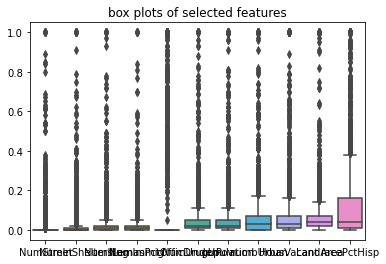

In [15]:
sns.boxplot(data=whole_set[selected_features[:-1]])
plt.title('box plots of selected features')
plt.show()

It is difficult to draw conclusions about significance of these features by the scatter plots between 11 features with highest CV and 
the plots between features versus the response variable, it is obvious that the points are dispersed through the last column from above plot. However, we can draw a conclusion that there is a significant correlation between 
population and numbUrban from the scatter plots. There are positive correlations between NumUnderPov and population as well as between NumUnderPov and numbUrban as well. From the box plots, we can observe that those features are distributed heavily near 0 and have relatively large standard deviation, so their CVs are high.

(f) Fit a linear model using least squares to the training set and report the test error.

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

X_train=trainingset.iloc[:,:-1]
Y_train=trainingset.iloc[:,-1]
X_test=testset.iloc[:,:-1]
Y_test=testset.iloc[:,-1]
lr_model=LinearRegression()
lr_model.fit(X_train,Y_train)
Y_pred=lr_model.predict(X_test)
MSE=metrics.mean_squared_error(Y_test,Y_pred)
print('mean squared error of the linear model on test set is',MSE)

mean squared error of the linear model on test set is 1.3006483853053395e+17


The MSE is abnormally large, let us detect what happened here.

In [52]:
dif=pd.DataFrame(Y_pred-Y_test) # the differences between responses and prediction values in test set
dif.sort_values(['ViolentCrimesPerPop'])

,ViolentCrimesPerPop
462,-5.330827e-01
168,-4.520486e-01
141,-4.477076e-01
115,-4.261245e-01
336,-3.956413e-01
...,...
203,3.709357e-01
493,4.342158e-01
327,5.415721e-01
384,6.193757e-01


It seems that there is something wrong within the 146th line in the test set whose difference between response and prediction is 8.056200e+09. 
So I tend to remove this outlier and observe the result again.

In [55]:
X_test_rev=X_test.drop(index=145)
Y_test_rev=Y_test.drop(index=145)
Y_pred_rev=lr_model.predict(X_test_rev)
MSE_rev=metrics.mean_squared_error(Y_test_rev,Y_pred_rev)
print('mean squared error of the linear model on revised test set is',MSE_rev)

mean squared error of the linear model on revised test set is 0.018059400622956603


The MSE decreased to 0.018059400622956603, it seems more reasonable now.

(g) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [19]:
from sklearn.linear_model import RidgeCV

alphas=[1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3,1e4] # increase the alpha exponentially
ridge_model=RidgeCV(alphas=alphas, cv=5)
ridge_model.fit(X_train,Y_train)
Y_pred1=ridge_model.predict(X_test)
MSE1=metrics.mean_squared_error(Y_test,Y_pred1)
print('The chosen λ by cross-validation is',ridge_model.alpha_)
print('mean squared error of the ridge regression model on test set is',MSE1)

The chosen λ by cross-validation is 1.0
mean squared error of the ridge regression model on test set is 0.01773247499289664


(h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the 
variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

In [21]:
from sklearn.linear_model import LassoCV

# features without standardization
lasso_model=LassoCV(alphas=alphas, cv=5)
lasso_model.fit(X_train,Y_train)
Y_pred2=lasso_model.predict(X_test)
MSE2=metrics.mean_squared_error(Y_test,Y_pred2)
print('The chosen λ by cross-validation is',lasso_model.alpha_)
print('mean squared error of the lasso regression model on test set is',MSE2)
coef1=pd.DataFrame(lasso_model.coef_,index=columns[5:-1])
print(coef1)
print('LASSO model picked',len(coef1[coef1[0]!=0]),'variables and eliminated the other',len(coef1[coef1[0]==0]),'variables')
selected_variables=coef1[coef1[0]!=0].index.tolist()
print('The list of variables selected by lasso model is',selected_variables)

The chosen λ by cross-validation is 0.0001
mean squared error of the lasso regression model on test set is 0.017786089519102124
                            0
population          -0.000000
householdsize        0.000000
racepctblack         0.273052
racePctWhite        -0.000000
racePctAsian        -0.017982
...                       ...
PolicOperBudg       -0.000000
LemasPctPolicOnPatr  0.021727
LemasGangUnitDeploy  0.040690
LemasPctOfficDrugUn  0.000618
PolicBudgPerPop      0.000000

[122 rows x 1 columns]
LASSO model picked 78 variables and eliminated the other 44 variables
The list of variables selected by lasso model is ['racepctblack', 'racePctAsian', 'agePct12t21', 'agePct12t29', 'agePct65up', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctBSorMore', 'PctEmploy', 'PctEmplManu', 'PctOccupManu', 'MalePctD

In [22]:
from sklearn import preprocessing

# features with standardization
std=preprocessing.StandardScaler()
std.fit(X_train)
X_train_std=std.transform(X_train)
X_test_std=std.transform(X_test)
lasso_model2=LassoCV(alphas=alphas, cv=5,max_iter=10000)
lasso_model2.fit(X_train_std,Y_train)
Y_pred3=lasso_model2.predict(X_test_std)
MSE3=metrics.mean_squared_error(Y_test,Y_pred3)
print('The chosen λ by cross-validation is',lasso_model2.alpha_)
print('After data standardization, mean squared error of the lasso regression model on test set is',MSE3)
coef2=pd.DataFrame(lasso_model2.coef_,index=columns[5:-1])
print(coef2)
print('LASSO model picked',len(coef2[coef2[0]!=0]),'variables and eliminated the other',len(coef2[coef2[0]==0]),'variables')
selected_variables2=coef2[coef2[0]!=0].index.tolist()
print('The list of variables selected by lasso model is',selected_variables2)

The chosen λ by cross-validation is 0.001
After data standardization, mean squared error of the lasso regression model on test set is 0.017758149260213713
                            0
population          -0.000000
householdsize        0.000000
racepctblack         0.066805
racePctWhite        -0.000000
racePctAsian        -0.000000
...                       ...
PolicOperBudg        0.000000
LemasPctPolicOnPatr  0.002066
LemasGangUnitDeploy  0.006239
LemasPctOfficDrugUn  0.000000
PolicBudgPerPop      0.000000

[122 rows x 1 columns]
LASSO model picked 68 variables and eliminated the other 54 variables
The list of variables selected by lasso model is ['racepctblack', 'agePct12t21', 'agePct12t29', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctEmploy', 'PctEmplManu', 'MalePctDivorce', 'MalePctNevMarr', 'Female

By comparing the results of both cases, we can observe that LASSO model on standardized data has a slight lower mean squared test error and LASSO model on standardized data selected less variables.

(i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error 
obtained.

The chosen M by cross-validation is 95 ,the corresponding validation error is 0.01945137759906606


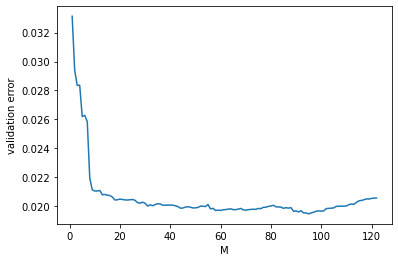

In [23]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

# First standardizing the predictors
# choose M
scores=[]
best_m=0
best_score=1
for m in range(1,123):
    pca=PCA(n_components=m)
    X_pc=pca.fit_transform(X_train_std)
    model0=LinearRegression()
    cvscore=cross_val_score(model0, X_pc, Y_train, cv=5, scoring = 'neg_mean_squared_error')
    score=sum(abs(cvscore))/len(cvscore)
    scores.append(score)
    if score<best_score:
        best_score=score
        best_m=m
        
print('The chosen M by cross-validation is',best_m,',the corresponding validation error is',best_score)
plt.plot(range(1,123), scores)
plt.xlabel('M')
plt.ylabel('validation error')
plt.show()

In [24]:
# best M is 95
pca=PCA(n_components=best_m)
X_pc_train=pca.fit_transform(X_train_std)
X_pc_test=pca.transform(X_test_std)
pcr_model=LinearRegression()
pcr_model.fit(X_pc_train,Y_train)
Y_pred4=pcr_model.predict(X_pc_test)
MSE4=metrics.mean_squared_error(Y_test,Y_pred4)
print('mean squared error of the PCR model on test set is',MSE4)

mean squared error of the PCR model on test set is 0.018391966692656483


(j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each 
node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression 
at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine α 
(the regularization term) using cross-validation.

In [25]:
import xgboost as xgb

datamatrix = xgb.DMatrix(data=X_train, label=Y_train)
best_alpha=None
best_score1=1
for a in alphas:
    para={'eta':0.1,'alpha':a} # L1-penalized regression
    errors=xgb.cv(para, datamatrix, num_boost_round=100, nfold=5, metrics='rmse')
    score=min(errors['test-rmse-mean']) # get the lowest validation error for each alpha
    if score<best_score1:
        best_alpha=a
        best_score1=score
        
print('The chosen alpha by cross-validation is',best_alpha,',the corresponding validation error is',best_score1)

The chosen alpha by cross-validation is 1 ,the corresponding validation error is 0.143282


In [26]:
para={'eta':0.1,'alpha':best_alpha}
xgb_model=xgb.train(params=para,dtrain=datamatrix)
testmatrix=xgb.DMatrix(data=X_test, label=Y_test)
Y_pred5=xgb_model.predict(testmatrix)
MSE5=metrics.mean_squared_error(Y_test,Y_pred5)
print('mean squared error of the XGBoost tree model on test set is',MSE5)

mean squared error of the XGBoost tree model on test set is 0.030960243269294408
